Epoch [10/100], Loss: 0.6964
Epoch [20/100], Loss: 0.6955
Epoch [30/100], Loss: 0.7171
Epoch [40/100], Loss: 0.6960
Epoch [50/100], Loss: 0.6942
Epoch [60/100], Loss: 0.6925
Epoch [70/100], Loss: 0.6774
Epoch [80/100], Loss: 0.6764
Epoch [90/100], Loss: 0.6910
Epoch [100/100], Loss: 0.6766
Train Accuracy: 0.5272, Precision: 0.5272, Recall: 1.0000, F1: 0.6904
Test Accuracy: 0.4945, Precision: 0.4945, Recall: 1.0000, F1: 0.6618
Validation Accuracy: 0.5510, Precision: 0.5510, Recall: 1.0000, F1: 0.7105
Validation results saved to 'validation_predictions_deep_rnn.csv'
Model saved to 'deep_rnn_model.pth'


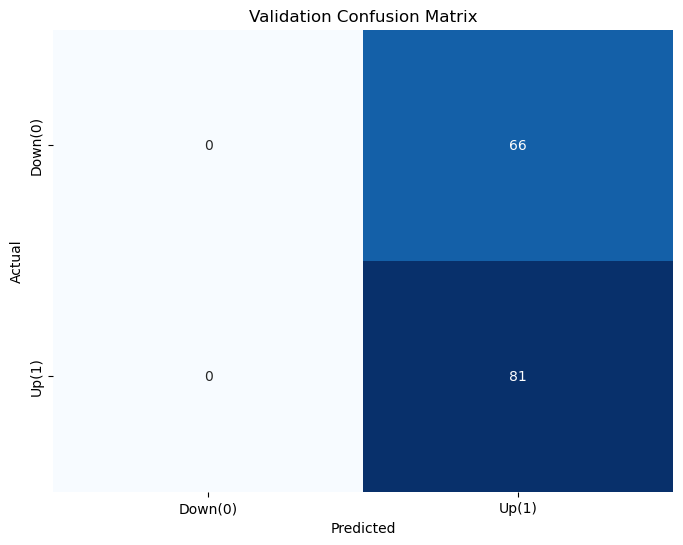

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 3.1 이동 평균 (5일 WMA)
def calculate_wma(data, period=5):
    weights = np.arange(1, period + 1)
    def wma(prices):
        return np.dot(prices, weights) / weights.sum()
    return data['closing_price'].rolling(period).apply(wma, raw=True)

df['wma_5'] = calculate_wma(df)

# 3.2 볼린저 밴드
def calculate_bollinger_bands(data, period=10):
    # 중간 밴드 (10일 SMA)
    data['middle_band'] = data['closing_price'].rolling(period).mean()
    
    # 표준편차 계산
    data['std'] = data['closing_price'].rolling(period).std()
    
    # 상단 밴드 및 하단 밴드 계산
    data['upper_band'] = data['middle_band'] + 2 * data['std']
    data['lower_band'] = data['middle_band'] - 2 * data['std']
    
    # %B 계산
    data['%B'] = (data['closing_price'] - data['lower_band']) / (data['upper_band'] - data['lower_band'])
    
    # 대역폭(BW) 계산
    data['bandwidth'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    
    return data

df = calculate_bollinger_bands(df)


# 3.3 RSI
def calculate_rsi(data, period=9):
    delta = data['closing_price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    rsi = rsi.replace([np.inf, -np.inf], np.nan) # inf 값을 nan 값으로 바꿈
    return rsi

df['rsi_9'] = calculate_rsi(df)

# 3.4 MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # EMA 계산
    ema_short = data['closing_price'].ewm(span=short_period, adjust=False).mean()
    ema_long = data['closing_price'].ewm(span=long_period, adjust=False).mean()

    # MACD 계산
    macd = ema_short - ema_long

    # MACD 신호 계산
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    
    return macd, signal

macd, signal = calculate_macd(df)
df['macd'] = macd
df['macd_signal'] = signal

# 3.5 Stochastic Oscillator
def calculate_stochastic_oscillator(data, period=5, d_period=3):
    # 최고가와 최저가 계산
    data['highest_5'] = data['high_price'].rolling(window=period).max()
    data['lowest_5'] = data['low_price'].rolling(window=period).min()

    # %K 계산
    data['%K'] = ((data['closing_price'] - data['lowest_5']) / (data['highest_5'] - data['lowest_5'])) * 100

    # %D 계산
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    
    data['%K'] = data['%K'].replace([np.inf, -np.inf], np.nan)
    
    return data

df = calculate_stochastic_oscillator(df)
df.dropna(inplace=True)

# 출력 변수 생성
df['price_change'] = df['closing_price'].diff()
df['output'] = (df['price_change'] > 0).astype(int)
df.drop(columns=['price_change'], inplace=True)

# 입력 변수 선택
input_features = [
    'opening_price', 'high_price', 'low_price', 'closing_price',
    'wma_5', 'middle_band', 'upper_band', 'lower_band', '%B', 'bandwidth',
    'rsi_9', 'macd', 'macd_signal', '%K', '%D'
]

# 데이터셋 분할
train_end_date = pd.to_datetime('2024-06-30')
validation_start_date = pd.to_datetime('2024-07-01')

# 훈련 데이터 및 테스트 데이터 분할 (2024년 6월 30일 이전 데이터)
train_df = df[df['datetime'] <= train_end_date]
train_size = int(len(train_df) * 0.7)  # 7:3 비율
train_df = train_df.reset_index(drop=True)

X_train = train_df[input_features][:train_size].values
y_train = train_df['output'][:train_size].values
X_test = train_df[input_features][train_size:].values
y_test = train_df['output'][train_size:].values


# 검증 데이터 분할 (2024년 7월 1일 이후 데이터)
validation_df = df[(df['datetime'] >= validation_start_date) & (df['datetime'] <= df['datetime'].max())]
X_validation = validation_df[input_features].values
y_validation = validation_df['output'].values
validation_dates = validation_df['datetime'].values

# 데이터 정규화 (Min-Max Scaling)
def min_max_scaling(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data,min_vals, max_vals

X_train_scaled,min_vals_train, max_vals_train= min_max_scaling(X_train)
X_test_scaled,min_vals_test,max_vals_test = min_max_scaling(X_test)
X_validation_scaled,min_vals_val,max_vals_val = min_max_scaling(X_validation)

# ----------------------------
# Deep RNN 모델 정의
# ----------------------------
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size=60, sequence_length=10, num_layers=5, dropout_prob = 0.2):
        super(DeepRNN, self).__init__()
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=num_layers, dropout=dropout_prob)
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # 완전 연결 레이어 추가
        self.relu = nn.ReLU()  # ReLU 활성화 함수 추가
        self.dropout = nn.Dropout(dropout_prob) # Dropout 추가
        self.fc2 = nn.Linear(hidden_size, 2)  # 최종 출력 레이어

    def forward(self, x):
         # x: [batch_size, seq_length, input_size]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # hidden state 초기화
        out, _ = self.rnn(x, h0) # RNN 레이어 통과
        out = self.fc1(out[:, -1, :]) # 최종 hidden state만 사용
        out = self.relu(out)  # 활성화 함수 적용
        out = self.dropout(out) # 드롭아웃 적용
        out = self.fc2(out) # 최종 출력 레이어
        return out
    

# 하이퍼파라미터 설정
input_size = len(input_features)
hidden_size = 60
sequence_length = 10
batch_size = 32
epochs = 100
learning_rate = 0.001 # 학습률 변경
num_layers = 5  # RNN 레이어 수
dropout_prob = 0.2 # 드롭아웃 비율

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 시퀀스 데이터 변환 함수
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), :-1]
        y = data[i + seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


# 시퀀스 데이터 생성 및 로더
X_train_seq, y_train_seq = create_sequences(np.hstack((X_train_scaled, y_train.reshape(-1, 1))), sequence_length)
X_test_seq, y_test_seq = create_sequences(np.hstack((X_test_scaled, y_test.reshape(-1, 1))), sequence_length)
X_val_seq, y_val_seq = create_sequences(np.hstack((X_validation_scaled, y_validation.reshape(-1, 1))), sequence_length)

train_dataset = TensorDataset(torch.Tensor(X_train_seq).to(device), torch.LongTensor(y_train_seq).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(X_test_seq).to(device), torch.LongTensor(y_test_seq).to(device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(torch.Tensor(X_val_seq).to(device), torch.LongTensor(y_val_seq).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
model = DeepRNN(input_size, hidden_size, sequence_length, num_layers, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
      print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 모델 평가 함수
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(actual_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(actual_labels, predictions, average='binary', zero_division=0)
    return accuracy, precision, recall, f1, predictions, actual_labels


# 모델 성능 평가 및 검증 데이터 예측 결과 저장
train_accuracy, train_precision, train_recall, train_f1,_,_ = evaluate_model(model, train_loader)
test_accuracy, test_precision, test_recall, test_f1,_,_ = evaluate_model(model, test_loader)
val_accuracy, val_precision, val_recall, val_f1, val_predictions, val_actual_labels = evaluate_model(model, val_loader)


print(f"Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# 검증 데이터 예측 결과 저장
val_results = pd.DataFrame({'datetime':validation_dates[sequence_length:], 'Actual': val_actual_labels, 'Predicted': val_predictions})
val_results['datetime'] = pd.to_datetime(val_results['datetime'])
val_results['datetime'] = val_results['datetime'].dt.strftime('%Y-%m-%d')
val_results.to_csv('validation_predictions_deep_rnn.csv', index=False)


# 모델 저장
torch.save(model.state_dict(), 'deep_rnn_model.pth')

print(f"Validation results saved to 'validation_predictions_deep_rnn.csv'")
print(f"Model saved to 'deep_rnn_model.pth'")

# ---------------------
# 혼동 행렬 시각화
# ---------------------

# 혼동 행렬 계산
cm = confusion_matrix(val_actual_labels, val_predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Down(0)', 'Up(1)'], 
            yticklabels=['Down(0)', 'Up(1)'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.savefig('confusion_matrix_deep_rnn.png')  # 이미지 파일로 저장
plt.show()